Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [7]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [8]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [9]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [10]:
import random

In [11]:
def show_images(folders):
    for folder in folders:
        images = os.listdir(folder)
        n_images = len(images)
        index = random.randint(0,n_images)
        path = folder +'/' +images[index]
        image = Image(filename=path)
        print('Letter', folder[-1])
        display(image)

### Training Samples

One random sample for each letter in the training data set.

In [12]:
show_images(train_folders)

Letter A


Letter B


Letter C


Letter D


Letter E


Letter F


Letter G


Letter H


Letter I


Letter J


### Testing samples

One random sample for each letter in the testing data set.

In [13]:
show_images(test_folders)

Letter A


Letter B


Letter C


Letter D


Letter E


Letter F


Letter G


Letter H


Letter I


Letter J


Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [14]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

notMNIST_large/A.pickle already present - Skipping pickling.
notMNIST_large/B.pickle already present - Skipping pickling.
notMNIST_large/C.pickle already present - Skipping pickling.
notMNIST_large/D.pickle already present - Skipping pickling.
notMNIST_large/E.pickle already present - Skipping pickling.
notMNIST_large/F.pickle already present - Skipping pickling.
notMNIST_large/G.pickle already present - Skipping pickling.
notMNIST_large/H.pickle already present - Skipping pickling.
notMNIST_large/I.pickle already present - Skipping pickling.
notMNIST_large/J.pickle already present - Skipping pickling.
notMNIST_small/A.pickle already present - Skipping pickling.
notMNIST_small/B.pickle already present - Skipping pickling.
notMNIST_small/C.pickle already present - Skipping pickling.
notMNIST_small/D.pickle already present - Skipping pickling.
notMNIST_small/E.pickle already present - Skipping pickling.
notMNIST_small/F.pickle already present - Skipping pickling.
notMNIST_small/G.pickle 

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

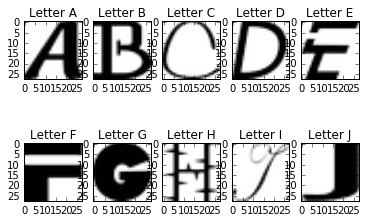

In [15]:
def display_images(dataset):
    for i in range(len(dataset)):
        pickle_file = dataset[i]  # index 0 should be all As, 1 = all Bs, etc.
        with open(pickle_file, 'rb') as f:
            letter_set = pickle.load(f)  # unpickle
            sample_idx = random.randint(0,len(letter_set))  # pick a random image index
            sample_image = letter_set[sample_idx, :, :]
            plt.subplot(2, 5, i+1)
            title = 'Letter ' + chr(i+65)
            plt.title(title)
            plt.imshow(sample_image,cmap='Greys')  # display it

display_images(train_datasets)
        

For each pickle (each letter folder) we pick a random sample to paint and paint the 28x28 grid of pixels, identifying it by the ASCII code (A=65, B=66...)

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

Do we have aproximately the same number of samples for each letter in both the training and the testing data sets?

In [16]:
def get_number_letters(dataset):
    for i in range(len(dataset)):
        pickle_file = dataset[i]  # index 0 should be all As, 1 = all Bs, etc.
        with open(pickle_file, 'rb') as f:
            letter_set = pickle.load(f)
            print('The number of letters', chr(65+i),'in the dataset is', len(letter_set))

### Training dataset

In [17]:
get_number_letters(train_datasets)

The number of letters A in the dataset is 52909
The number of letters B in the dataset is 52911
The number of letters C in the dataset is 52912
The number of letters D in the dataset is 52911
The number of letters E in the dataset is 52912
The number of letters F in the dataset is 52912
The number of letters G in the dataset is 52912
The number of letters H in the dataset is 52912
The number of letters I in the dataset is 52912
The number of letters J in the dataset is 52911


### Test dataset

In [18]:
get_number_letters(test_datasets)

The number of letters A in the dataset is 1872
The number of letters B in the dataset is 1873
The number of letters C in the dataset is 1873
The number of letters D in the dataset is 1873
The number of letters E in the dataset is 1873
The number of letters F in the dataset is 1872
The number of letters G in the dataset is 1872
The number of letters H in the dataset is 1872
The number of letters I in the dataset is 1872
The number of letters J in the dataset is 1872


As can be seen, both data sets are almost perfectly balanced.

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [19]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [20]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

The samples have been shuffled by index, so the correspondence Sample-Label remains intact. It can be easily seen by painting the first 10 letters of the data set and their label.

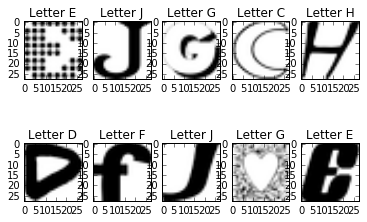

In [21]:
for i in range(10):
    plt.subplot(2, 5, i+1 )
    title = 'Letter ' + chr(train_labels[i]+65)
    plt.title(title)
    plt.imshow(train_dataset[i],cmap='Greys')  # display it

#The data is still reliable!

Finally, let's save the data for later reuse:

In [22]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [23]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800503


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

To find duplicates between two sets in an efficient way, we first convert the 28x28 grid in a 784 tuple vector. Once that's been done, we use the tuple as key and the index as value of the dictionary. This way it will be easier to know if a certain tuple is contained in the dictionary.

In [24]:
def to_map(dataset):
    data_map = {}
    repeated = []
    for i in range(dataset.shape[0]):
        if tuple(dataset[i].flatten()) in data_map:
            repeated.append(i)
        else:
            data_map[tuple(dataset[i].flatten())] = i
    return data_map, repeated


train_map, train_repeated = to_map(train_dataset)
test_map, test_repeated = to_map(test_dataset)
valid_map, valid_repeated = to_map(valid_dataset)

To find the elements of the array one that exist in the array two (overlapping) we iterate through the elements of the first one and check if they exist as keys in the second one.

In [25]:
def overlaps(first_map, second_map):
    overlapping = []
    for key, value in first_map.items():
        if key in second_map.keys():
            overlapping.append(value)
    return overlapping

test_train_overlaps = overlaps(test_map, train_map)
valid_train_overlaps = overlaps(valid_map, train_map)

### Test data set

In [26]:
n_test_overlapped = len(test_train_overlaps)
n_test_repeated = len(test_repeated)
n_test = len(test_map)
print('Overlapped with Training set: ' + str(n_test_overlapped) + ' out of ' + str(n_test) + '-->' +  str(n_test_overlapped * 100/n_test) + '%')
print('Repeated in the Test set: ' +  str(n_test_repeated) + ' out of ' + str(n_test) + '--> ' + str(n_test_repeated * 100/n_test) + '%')

Overlapped with Training set: 1153 out of 9780-->11.789366053169735%
Repeated in the Test set: 220 out of 9780--> 2.2494887525562373%


### Valid data set

In [27]:
n_valid_overlapped = len(valid_train_overlaps)
n_valid_repeated = len(valid_repeated)
n_valid = len(valid_map)
print('Overlapped with Training set: ' + str(n_valid_overlapped) + ' out of ' + str(n_valid) + '-->' +  str(n_valid_overlapped * 100/n_valid) + '%')
print('Repeated in the Valid set: ' +  str(n_valid_repeated) + ' out of ' + str(n_valid) + '--> ' + str(n_valid_repeated * 100/n_valid) + '%')

Overlapped with Training set: 953 out of 9872-->9.65356564019449%
Repeated in the Valid set: 128 out of 9872--> 1.2965964343598055%


To sanitize the data sets, both repeated (multiple times in the set) and overlapped elements with the training set (it isn't convenient to test with the same elements it has been trained with) must be deleted.

### Sanitized Test set

In [28]:
sanitized_test_dataset = np.delete(test_dataset[:], test_train_overlaps, axis=0)
sanitized_test_dataset = np.delete(sanitized_test_dataset[:], test_repeated, axis=0)
sanitized_test_labels = np.delete(test_labels[:], test_train_overlaps, axis=0)
sanitized_test_labels = np.delete(sanitized_test_labels[:], test_repeated, axis=0)

### Sanitized Valid set

In [29]:
sanitized_valid_dataset = np.delete(valid_dataset[:], valid_train_overlaps, axis=0)
sanitized_valid_dataset = np.delete(sanitized_valid_dataset[:], valid_repeated, axis=0)
sanitized_valid_labels = np.delete(valid_labels, valid_train_overlaps)
sanitized_valid_labels = np.delete(sanitized_valid_labels, valid_repeated)

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

For each samples length, we create a new Logistic Regression and clip the different data sets to their new shape. As the Logistic Regression must be performed with a 2D Array (right now we have a 3D Array), the second and third dimensions are reshaped to be flattened as a single dimension (28x28 grid is converted to a file vector of length 784). For each Regression, we fit it with the training data and chech the accuracy of the predictions with the validation set and the testing set.

### Valid and test data sets

In [31]:
lengths = [50, 100, 1000, 5000]

for l in lengths:
    logistic = LogisticRegression()
    
    train_samples = train_dataset[:l]
    train_samples = train_samples.reshape(train_samples.shape[0],train_samples.shape[1]*train_samples.shape[2])
    
    train_y = train_labels[0:l]
    
    valid_samples = valid_dataset[:l]
    valid_samples = valid_samples.reshape(valid_samples.shape[0],valid_samples.shape[1]*valid_samples.shape[2])
    
    sanitized_valid_samples = sanitized_valid_dataset[:l]
    sanitized_valid_samples = sanitized_valid_samples.reshape(sanitized_valid_samples.shape[0],sanitized_valid_samples.shape[1]*sanitized_valid_samples.shape[2])

    valid_y = valid_labels[:l]
    sanitized_valid_y = sanitized_valid_labels[:l]

    test_samples = test_dataset[:l]
    test_samples = test_samples.reshape(test_samples.shape[0],test_samples.shape[1]*test_samples.shape[2])
    
    sanitized_test_samples = sanitized_test_dataset[:l]
    sanitized_test_samples = sanitized_test_samples.reshape(sanitized_test_samples.shape[0],sanitized_test_samples.shape[1]*sanitized_test_samples.shape[2])
    
    test_y = test_labels[:l]
    sanitized_test_y = sanitized_test_labels[:l]
    
    logistic.fit(train_samples, train_y)
    
    print('Validation set with', l, 'samples, accuracy of',logistic.score(valid_samples, valid_y) )
    print('Sanitized validation set with', l, 'samples, accuracy of',logistic.score(sanitized_valid_samples, sanitized_valid_y) )
    print('Test set with', l, 'samples, accuracy of',logistic.score(test_samples, test_y) )
    print('Sanitized test set with', l, 'samples, accuracy of',logistic.score(sanitized_test_samples, sanitized_test_y) )
    print('-----------------------------------------')

Validation set with 50 samples, accuracy of 0.48
Sanitized validation set with 50 samples, accuracy of 0.48
Test set with 50 samples, accuracy of 0.46
Sanitized test set with 50 samples, accuracy of 0.36
-----------------------------------------
Validation set with 100 samples, accuracy of 0.67
Sanitized validation set with 100 samples, accuracy of 0.68
Test set with 100 samples, accuracy of 0.64
Sanitized test set with 100 samples, accuracy of 0.67
-----------------------------------------
Validation set with 1000 samples, accuracy of 0.736
Sanitized validation set with 1000 samples, accuracy of 0.733
Test set with 1000 samples, accuracy of 0.839
Sanitized test set with 1000 samples, accuracy of 0.844
-----------------------------------------
Validation set with 5000 samples, accuracy of 0.7698
Sanitized validation set with 5000 samples, accuracy of 0.7596
Test set with 5000 samples, accuracy of 0.8526
Sanitized test set with 5000 samples, accuracy of 0.8454
--------------------------

As could be imagined, the bigger the sample set size the better the accuracy. 

With the sanitized sets, the accuracy is slightly lower than with the original sets (it becomes clearer with a big number of samples). This is caused because we have removed all the items located in both the Training set and the Testing/Valid set. This repetitions were overestimating the accuracy of the regression.

### For the whole dataset

For this case we need a faster solver of the Regression. As it's recommended in the scikit-learn documentation, Stochastic Average Gradient descent solver is the best one for large datasets.

In [32]:
logistic = LogisticRegression(solver='sag')
train_samples = train_dataset
train_samples = train_samples.reshape(train_samples.shape[0],train_samples.shape[1]*train_samples.shape[2])

train_y = train_labels

test_samples = test_dataset
test_samples = test_samples.reshape(test_samples.shape[0],test_samples.shape[1]*test_samples.shape[2])

sanitized_test_samples = sanitized_test_dataset
sanitized_test_samples = sanitized_test_samples.reshape(sanitized_test_samples.shape[0],sanitized_test_samples.shape[1]*sanitized_test_samples.shape[2])

test_y = test_labels
sanitized_test_y = sanitized_test_labels

logistic.fit(train_samples, train_y)
print('Test set with', len(test_samples), 'samples, accuracy of',logistic.score(test_samples, test_y) )
print('Sanitized test set with', len(sanitized_test_samples), 'samples, accuracy of',logistic.score(sanitized_test_samples, sanitized_test_y) )

Test set with 10000 samples, accuracy of 0.8932
Sanitized test set with 8656 samples, accuracy of 0.88435767098


Again, with the sanitized set the accuracy is slightly lower, same reasoning as before.

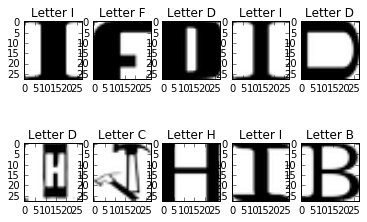

In [76]:
y_pred = logistic.predict(test_samples)

rand_indexes = np.random.randint(0, len(y_pred), 10)

i=1
for r in rand_indexes:
    image = test_samples[r].reshape(28,28)
    label = y_pred[r]
    plt.subplot(2, 5, i)
    title = 'Letter ' + chr(label+65)
    plt.title(title)
    plt.imshow(image,cmap='Greys')  # display it
    i += 1


As can be seen, statistically nine out of ten images are going to be well predicted (0.8932 accuracy).